In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import glob

# Generate the ArUco Markers.

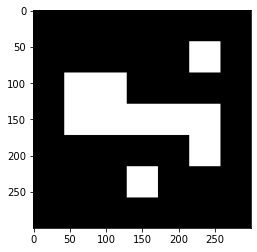

In [2]:
%matplotlib inline
tag1 = np.zeros((300, 300, 1), dtype="uint8")

dictionary = aruco.Dictionary_get(aruco.DICT_5X5_250)
aruco.drawMarker(dictionary, 248, 300, tag1, 1)

fig = plt.figure()
plt.imshow(tag1, cmap = plt.cm.gray)


# Calibrate the camera.

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def calibrate(dirpath, prefix, image_format, square_size, width=9, height=6):
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob(dirpath+'/' + prefix + '*.' + image_format)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]


In [4]:
def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

In [5]:
ret, mtx, dist, rvecs, tvecs = calibrate('calibrate_images/13_pro_img/', 'img', 'jpg', 0.024, 9, 6)
save_coefficients(mtx, dist, '13pro_coef_img')
print("Calibration is finished. RMS: ", ret)

Calibration is finished. RMS:  8.876811870832384


In [6]:
[camera_matrix, dist_matrix] = load_coefficients('13pro_coef')

In [7]:
def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=3,
          font_thickness=2,
          text_color=(0, 255, 0),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y - text_h - 15), text_color_bg, -1)
    cv2.putText(img, text, (x, y - font_scale - 10), font, font_scale, text_color, font_thickness)


In [8]:
def detect_landing_pad(input_video):

    width = input_video.get(cv2. CAP_PROP_FRAME_WIDTH )   # float `width`
    height = input_video.get(cv2. CAP_PROP_FRAME_HEIGHT )  # float `height`
    size = (int(width), int(height))
    fps = input_video.get(cv2. CAP_PROP_FPS)

    list_frames_detection = []

    while True:
        ret, frame = input_video.read()
        if ret == False:
            break
        # operations on the frame come here
        aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)  # Use 5x5 dictionary to find markers
        parameters = aruco.DetectorParameters_create()  # Marker detection parameters

        corners, ids, rejected = cv2.aruco.detectMarkers(image=frame, dictionary=aruco_dict, parameters=parameters)
        color = (0,0,255)

        if len(corners) == 4:
            point_1 = [int(i) for i in (corners[np.where(ids==248)[0][0]][0][0])]
            point_2 = [int(i) for i in (corners[np.where(ids==200)[0][0]][0][1])]
            point_3 = [int(i) for i in (corners[np.where(ids==150)[0][0]][0][3])]
            point_4 = [int(i) for i in (corners[np.where(ids==100)[0][0]][0][2])]
            cv2.line(frame, point_1,point_2, color, 2)
            cv2.line(frame, point_3,point_4, color, 2)
            cv2.line(frame, point_1,point_3, color, 2)
            cv2.line(frame, point_2,point_4, color, 2)


            draw_text(frame, "Landing Pad", font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, pos=point_1, text_color_bg=color, text_color=(255,255,255))

        else:
            x_coors = np.array([])
            y_coors = np.array([])
            for corner in corners:
                x_coors = np.append(x_coors, corner.T[0])
                y_coors = np.append(y_coors, corner.T[1])
            if x_coors.any() or y_coors.any():
                x_min = np.min(x_coors)
                y_min = np.min(y_coors)
                x_max = np.max(x_coors)
                y_max = np.max(y_coors)
            cv2.rectangle(frame, (int(x_max),int(y_max)), (int(x_min), int(y_min)), color, 2)

            org = (int(x_min), int(y_min))
            
            draw_text(frame, "Landing Pad", font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, pos=org, text_color_bg=color, text_color=(255,255,255))

        list_frames_detection.append(frame)



    out = cv2.VideoWriter('detection.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(list_frames_detection)):
        out.write(list_frames_detection[i])
    out.release()

    print("Output Saved to detection.mp4")


In [9]:
import time
st = time.time()
detect_landing_pad(cv2.VideoCapture('test_videos/testbox.mp4'))
time_cost = time.time() - st
print("The time cost for this 16s image is {:.3}s.".format(time_cost))

Output Saved to detection.mp4
The time cost for this 16s image is 5.52s.


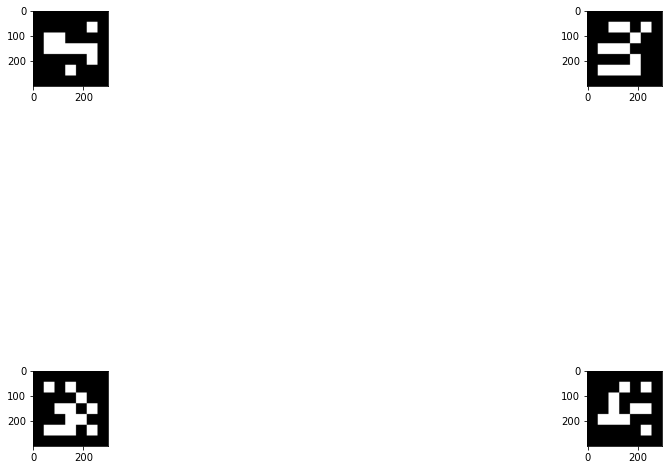

In [10]:
%matplotlib inline
tag1 = np.zeros((300, 300, 1), dtype="uint8")
tag2 = np.zeros((300, 300, 1), dtype="uint8")
tag3 = np.zeros((300, 300, 1), dtype="uint8")
tag4 = np.zeros((300, 300, 1), dtype="uint8")
dictionary = aruco.Dictionary_get(aruco.DICT_5X5_250)
aruco.drawMarker(dictionary, 248, 300, tag1, 1)
aruco.drawMarker(dictionary, 200, 300, tag2, 1)
aruco.drawMarker(dictionary, 150, 300, tag3, 1)
aruco.drawMarker(dictionary, 100, 300, tag4, 1)
fig = plt.figure(num=1, figsize=(12, 8))
# draw the corresponding histogram
plt.subplot(5, 5, 1)
plt.imshow(tag1, cmap = plt.cm.gray)
plt.subplot(5, 5, 5)
plt.imshow(tag2, cmap = plt.cm.gray)
plt.subplot(5, 5, 21)
plt.imshow(tag3, cmap = plt.cm.gray)
plt.subplot(5, 5, 25)
plt.imshow(tag4, cmap = plt.cm.gray)